# Required Libraries

In [1]:
import os
import glob
import fnmatch
import pandas as pd
import numpy as np
import seaborn as sns
import librosa 
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import math
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = "//kaggle/input/pig-disease-f/data 2/Train"
print(os.listdir(data_path))

['prrs', 'swine_fever', 'Pnemonia']


# Exploratory Data Analysis

In [3]:
metadata = pd.read_csv('//kaggle/input/pig-data/data.csv')
metadata.head(10)

,slice_file_name,classID
0,pnu_1_faster.wav,1
1,pnu_1_noisy.wav,1
2,pnu_1_pitch_shifted.wav,1
3,pnu_1_reversed.wav,1
4,pnu_1_shifted.wav,1
5,pnu_1_slower.wav,1
6,pnu_1_stretched.wav,1
7,pnu_2_faster.wav,1
8,pnu_2_noisy.wav,1
9,pnu_2_pitch_shifted.wav,1


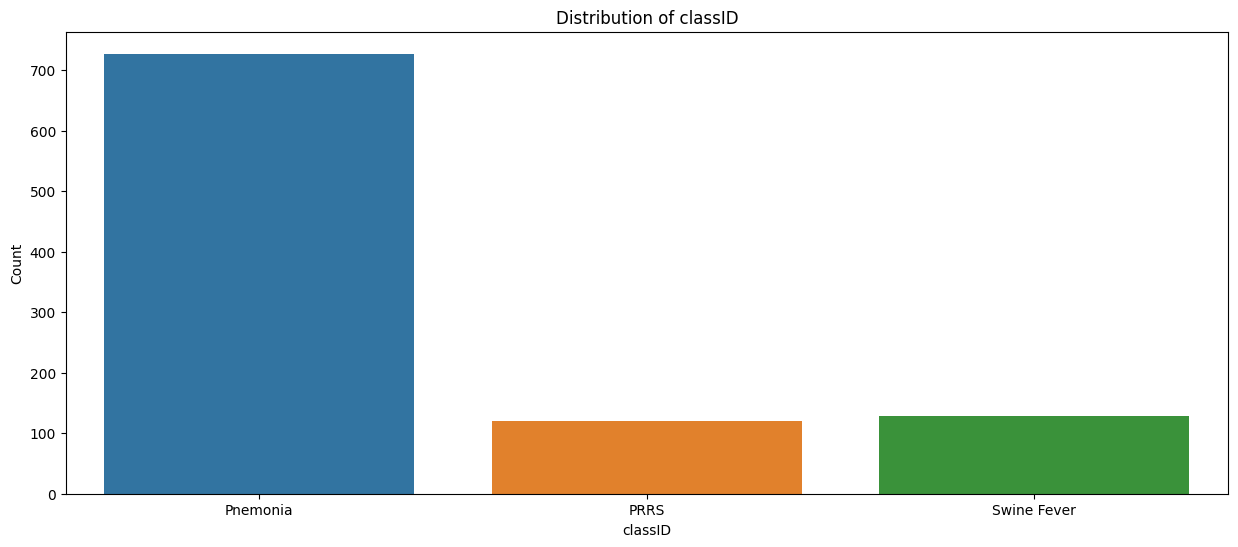

In [4]:
class_names = {
    1: 'Pnemonia',
    2: 'PRRS',
    3: 'Swine Fever'
    # Add more class IDs and their corresponding names as needed
}

# Map the class IDs to their names
metadata['class_name'] = metadata['classID'].map(class_names)


# Create a countplot to visualize the distribution of 'classID'
plt.figure(figsize=(15, 6))
sns.countplot(x='class_name', data=metadata)
plt.title('Distribution of classID')
plt.xlabel('classID')
plt.ylabel('Count')
plt.show()

In [ ]:
training_data      = data_path + "/Train/"

training_data_pnemonia      = data_path + "/Pnemonia/"
training_data_prrs       = data_path  + "/prrs/"
training_data_swine      = data_path  + "/swine_fever/"

# Exploratory Data Analysis

In [ ]:
sample_audio = "/kaggle/input/pig-disease-f/data 2/Train/Pnemonia/sam_1.wav"
ipd.Audio(sample_audio)

In [ ]:
data, sample_rate = librosa.load(sample_audio)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(data, sr=sample_rate)

when we load the data with librosa, then it normalizes the entire data and tries to give it in a single sample rate

In [ ]:
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(sample_audio)
print(wave_sample_rate)
print(wave_audio)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

when we print the data retrieved from librosa, it can be normalized, but when we try to read an audio file using scipy, it can’t be normalized.

In [ ]:
print("Training sounds in pnemonia : ", len(os.listdir(training_data_pnemonia)))
print("Training sounds in prrs: ", len(os.listdir(training_data_prrs)))
print("Training sounds in swine disease: ", len(os.listdir(training_data_swine)))

In [ ]:
"""
x = np.array([
    len(os.listdir(training_data_pnemonia)),
    len(os.listdir(training_data_prrs)),
    len(os.listdir(training_data_swine))  # Include data for swine
])

labels = ['Pnemonia', 'Prrs', 'Swine']  # Update the labels accordingly

plt.pie(x, labels=labels, autopct='%.0f%%', radius=1.5, textprops={'fontsize': 16})
plt.show()
"""

In [ ]:
# List of the folders (one for each class or disease)
class_folders = ['Pnemonia', 'prrs','swine_fever']

In [ ]:
# Initialize lists to store your audio data and labels
audio_data = []
labels = []

# Data Preprocessing

In [ ]:
# Data Preprocessing
scaler = StandardScaler()

In [ ]:
# Loop through the class folders and load and preprocess audio data
for folder in class_folders:
    folder_path = os.path.join(data_path, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):  # Adjust the file format if needed
            audio_path = os.path.join(folder_path, filename)

            # Load audio data and get the sample rate
            audio, sr = librosa.load(audio_path, sr=None)
            # Compute the spectrogram
            spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
            log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
            # Append the audio data to the list
            audio_data.append(audio)

            # Assign a label to the audio data (e.g., based on the folder/class)
            labels.append(folder)



In [ ]:
# Data Exploration and Visualization
plt.figure(figsize=(20, 10))
# Visualize the waveforms of a few audio samples
for i in range(5):  # Change the number of samples to visualize as needed
    plt.subplot(2, 3, i + 1)
    librosa.display.waveshow(audio_data[i], sr=sr)
    plt.title(f'{labels[i]} - Sample {i + 1}')

# Data Preprocessing

## MFCCs

In [ ]:
mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
print("\nShape of Features Extracted from Mel-frequency cepstral coefficients (MFCCs):")
print(mfccs.shape)
print("\nFeatures Extracted from Mel-frequency cepstral coefficients (MFCCs):\n")
print(mfccs)

In [ ]:
# Initialize lists to store features and labels
extracted_features = []

for folder in class_folders:
    folder_path = os.path.join(data_path, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(folder_path, filename)
            
            # Load audio data
            audio_data, sample_rate = librosa.load(file_path)
            
            # Extract features (e.g., MFCCs)
            mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=20)
            # Convert MFCCs to a 1D array or a list
            flattened_mfccs = mfccs.ravel().tolist()  # Convert to a list
            
            # Store the features and corresponding label as a dictionary
            extracted_features.append({'feature': flattened_mfccs, 'class': folder})

            

In [ ]:
#Convert the features to a Pandas dataframe
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])
print("\nFeatures Extracted from Mel-frequency cepstral coefficients (MFCCs) and Converted :")
extracted_features_df

In [ ]:
# Assuming your data is in a DataFrame named df
extracted_features_df['feature'].apply(lambda x: len(x)).plot(kind='hist', bins=25)
plt.title('Distribution of Feature Lengths')
plt.xlabel('Feature Length')
plt.ylabel('Frequency')
plt.show()

## Data Transformation

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'extracted_features_df' contains your feature data and labels

# Padding sequences to the same length
max_length = max(len(seq) for seq in extracted_features_df['feature'])
padded_sequences = pad_sequences(extracted_features_df['feature'], maxlen=max_length, padding='post')
# Display the padded sequences
for i, seq in enumerate(padded_sequences[:10]):
    print(f"Sequence {i + 1} (padded): {seq}")


In [ ]:
# Converting to NumPy arrays
X = np.array(padded_sequences)
y = np.array(extracted_features_df['class'])
### Label Encoding -> Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
print("number of data points in the training and testing sets") 
print(f"Number of data points in training set: {len(X_train)}")
print(f"Number of data points in testing set: {len(X_test)}")

# Model Implementation
## Dense Net

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
### No of classes
num_labels=y.shape[1]
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(3900,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
num_epochs = 10
num_batch_size = 32
checkpointer = ModelCheckpoint(filepath='./audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()
model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

In [ ]:
#model.predict_classes(X_test)
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
print(classes_x)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming model is your trained neural network model and X_test, y_test are your test data
# test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# If you've already calculated accuracy using model.evaluate, you can use it directly
# accuracy = test_accuracy[1]

# If you prefer calculating accuracy using scikit-learn's accuracy_score
predictions = model.predict(X_test)
predicted_classes = predictions.argmax(axis=1)
true_classes = y_test.argmax(axis=1)

accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy}")

# Precision, Recall, F1 Score
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)


# Machine Learning Models
## SVC

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Split the data into features (X) and labels (y)
X = extracted_features_df['feature'].to_list()  # Features
y = extracted_features_df['class']  # Labels

# Find the maximum length of all MFCCs
max_length = max(len(x) for x in X)

# Pad or truncate each feature to make them all the same length
X_padded = [np.pad(x, pad_width=((0, max_length - len(x))), mode='constant') if len(x) < max_length else x[:max_length] for x in X]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the SVC model
svc = SVC(kernel='linear')  # You can specify the kernel type (e.g., 'linear', 'rbf', etc.)

# Train the SVC model
svc.fit(X_train, y_train)

# Predict using the trained model
predictions = svc.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# F1 Score
f1 = f1_score(y_test, predictions, average='weighted')
print(f"F1 Score: {f1}")

# Precision
precision = precision_score(y_test, predictions, average='weighted')
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_test, predictions, average='weighted')
print(f"Recall: {recall}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline

# Combine feature scaling and SVC into a pipeline
model = make_pipeline(StandardScaler(), SVC(kernel='linear'))

# Create a cross-validation strategy (Stratified K-Folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X_padded, y, cv=cv, scoring='f1_weighted')

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))


# Random Forest Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


X = extracted_features_df['feature'].to_list()  # Features
y = extracted_features_df['class']  # Labels

# Find the maximum length of all MFCCs
max_length = max(len(x) for x in X)

# Pad or truncate each feature to make them all the same length
X_padded = [np.pad(x, pad_width=((0, max_length - len(x))), mode='constant') if len(x) < max_length else x[:max_length] for x in X]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of estimators based on your needs

# Train the Random Forest model
rf_classifier.fit(X_train, y_train)

# Predict using the trained model
predictions = rf_classifier.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# F1 Score
f1 = f1_score(y_test, predictions, average='weighted')
print(f"F1 Score: {f1}")

# Precision
precision = precision_score(y_test, predictions, average='weighted')
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_test, predictions, average='weighted')
print(f"Recall: {recall}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)


# Decision Tree Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Split the data into features (X) and labels (y)
X = extracted_features_df['feature'].to_list()  # Features
y = extracted_features_df['class']  # Labels

# Find the maximum length of all MFCCs
max_length = max(len(x) for x in X)

# Pad or truncate each feature to make them all the same length
X_padded = [np.pad(x, pad_width=((0, max_length - len(x))), mode='constant') if len(x) < max_length else x[:max_length] for x in X]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the Decision Tree model
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree model
dt_classifier.fit(X_train, y_train)

# Predict using the trained model
predictions = dt_classifier.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# F1 Score
f1 = f1_score(y_test, predictions, average='weighted')
print(f"F1 Score: {f1}")

# Precision
precision = precision_score(y_test, predictions, average='weighted')
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_test, predictions, average='weighted')
print(f"Recall: {recall}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)
